# Bonus1: Parallel Algorithms

### Name: [Your-Name?]


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)

2. Implement federated averaging or decentralized optimization.

3. Plot the convergence curve. (The x-axis can be ```number of epochs``` or ```number of communication```. You must make sure the label is correct.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo. (If it is submitted to Google Drive or Dropbox, you must make the file open-access.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus1/Bonus1.html



# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [1]:
# ! pip freeze

In [2]:

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import os
import numpy as np
from time import time
import matplotlib.pyplot as plt
# import federated_averaging_optimizer

In [3]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [4]:
import pandas as pd

In [7]:
df=pd.DataFrame(x)

In [8]:
display(df)


,0,1,2,3,4,5,6,7
0,6.0,148.0,72.0,35.0,0.0,33.599998,0.627,50.0
1,1.0,85.0,66.0,29.0,0.0,26.600000,0.351,31.0
2,8.0,183.0,64.0,0.0,0.0,23.299999,0.672,32.0
3,1.0,89.0,66.0,23.0,94.0,28.100000,0.167,21.0
4,0.0,137.0,40.0,35.0,168.0,43.099998,2.288,33.0
...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,180.0,32.900002,0.171,63.0
764,2.0,122.0,70.0,27.0,0.0,36.799999,0.340,27.0
765,5.0,121.0,72.0,23.0,112.0,26.200001,0.245,30.0
766,1.0,126.0,60.0,0.0,0.0,30.100000,0.349,47.0


In [9]:
display(df.describe())

,0,1,2,3,4,5,6,7
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.299999,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.599998,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.099998,2.420000,81.000000


In [67]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [68]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.01988454  0.13053054  0.13929711  0.05851485 -0.07120218  0.06150207
  -0.08059155  0.05183401]]
test std = 
[[0.97923808 1.06461451 0.88133722 1.00874805 0.95874181 0.90763849
  0.84780095 0.98150316]]


## 1.4. Add a dimension of all ones

In [69]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


In [91]:
# Define an object
model = tf.keras.models.Sequential()
# sequence of layers
# Adding first fully connected hidden layer
# 1) units (No of neurons) = 512
# 2) activation function = ReLU
# 3) input shape = 9
model.add(tf.keras.layers.Dense(units=512, activation='relu', input_shape=(9,)))

# Adding the second layer with dropout
model.add(tf.keras.layers.Dropout(0.3))

# sequence of layers
# Adding first fully connected hidden layer
# 1) units (No of neurons) = 256
# 2) activation function = ReLU
model.add(tf.keras.layers.Dense(units=256, activation='relu', input_shape=(9,)))

# Adding the second layer with dropout
model.add(tf.keras.layers.Dropout(0.3))

# sequence of layers
# Adding first fully connected hidden layer
# 1) units (No of neurons) = 128
# 2) activation function = ReLU
model.add(tf.keras.layers.Dense(units=128, activation='relu', input_shape=(9,)))

# Adding the second layer with dropout
model.add(tf.keras.layers.Dropout(0.3))

# sequence of layers
# Adding first fully connected hidden layer
# 1) units (No of neurons) = 64
# 2) activation function = ReLU
model.add(tf.keras.layers.Dense(units=64, activation='relu', input_shape=(9,)))

# Adding the second layer with dropout
model.add(tf.keras.layers.Dropout(0.3))

# regularization technique, prevents overfitting
# Adding the output layer
# 1) units = 1
# 2) activation = softmax
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Compiling the model
# 1) Optimizer = adam, (minimize the loss function)
# 2) loss function = binary_crossentropy, (acts as guide to optimizer)
# 3) metrices = accuracy

model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 512)               5120      
_________________________________________________________________
dropout_33 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_34 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_35 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 64)              

In [92]:
# Training the model
history=model.fit(x_train_1,y_train_1, epochs=20,validation_split=0.2)

Epoch 1/20
16/16 [==============================] - 1s 20ms/step - loss: 0.6545 - accuracy: 0.6053 - val_loss: 0.5587 - val_accuracy: 0.7031
Epoch 2/20
16/16 [==============================] - 0s 11ms/step - loss: 0.4979 - accuracy: 0.7600 - val_loss: 0.6017 - val_accuracy: 0.6797
Epoch 3/20
16/16 [==============================] - 0s 10ms/step - loss: 0.4490 - accuracy: 0.7855 - val_loss: 0.6065 - val_accuracy: 0.6641
Epoch 4/20
16/16 [==============================] - 0s 11ms/step - loss: 0.4509 - accuracy: 0.7945 - val_loss: 0.6071 - val_accuracy: 0.6797
Epoch 5/20
16/16 [==============================] - 0s 10ms/step - loss: 0.4129 - accuracy: 0.7977 - val_loss: 0.6417 - val_accuracy: 0.6953
Epoch 6/20
16/16 [==============================] - 0s 10ms/step - loss: 0.4509 - accuracy: 0.7938 - val_loss: 0.6209 - val_accuracy: 0.6562
Epoch 7/20
16/16 [==============================] - 0s 10ms/step - loss: 0.4161 - accuracy: 0.8209 - val_loss: 0.6441 - val_accuracy: 0.6953
Epoch 8/20
16

In [93]:
def learning_curve(history):

  # training vs validation accuracy
  epoch_range = range(1, len(history.history['accuracy'])+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'val'], loc='upper left')
  plt.show()

  # training vs validation loss
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'val'], loc='upper left')
  plt.show()

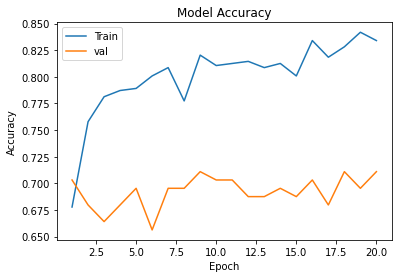

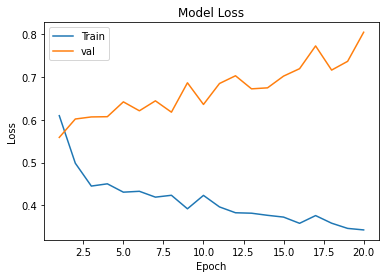

In [94]:
learning_curve(history)

In [95]:
# Model evaluation
test_loss, test_accuracy = model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 5ms/step - loss: 0.4277 - accuracy: 0.5391


In [96]:
print('Test Accuracy: {}'.format(test_accuracy))

Test Accuracy: 0.5390625


In [99]:
# Model prediction
y_pred = model.predict_classes(x_test_1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [100]:

# Confusion metrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test_1,y_pred)
print(cm)

[[29 15]
 [15 69]]
